In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

def build_dataframe(data_dir):
    data = []
    for person in sorted(os.listdir(data_dir)):
        for eye in ["L", "R"]:
            path = os.path.join(data_dir, person, eye)
            if not os.path.isdir(path): continue
            for img in os.listdir(path):
                if img.lower().endswith(('.jpg', '.png', '.bmp')):
                    data.append((f"{person}-{eye}", os.path.join(path, img)))
    return pd.DataFrame(data, columns=["Label", "Path"])

df = build_dataframe("/content/drive//MyDrive/AML-PROJECT/CASIA-Iris-Thousand/")
print(df.head())
print("Total samples:", len(df))
print("Total unique identities:", df['Label'].nunique())


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive//MyDrive/AML-PROJECT/CASIA-Iris-Thousand/'

In [ ]:
df.to_csv('/content/drive/MyDrive/AML-PROJECT/iris.csv', index=False)
print("saved")


saved


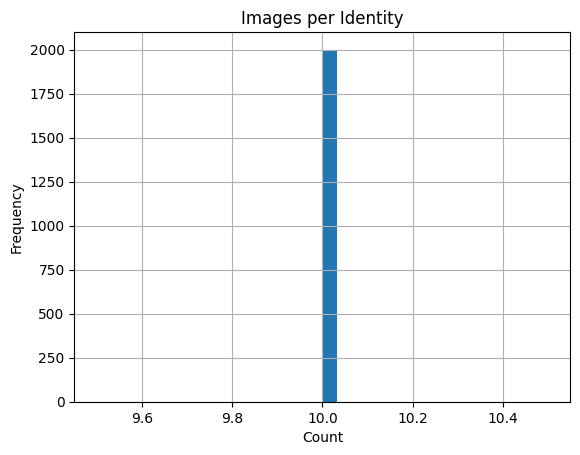

In [ ]:
import matplotlib.pyplot as plt
df['Label'].value_counts().hist(bins=30)
plt.title("Images per Identity")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()


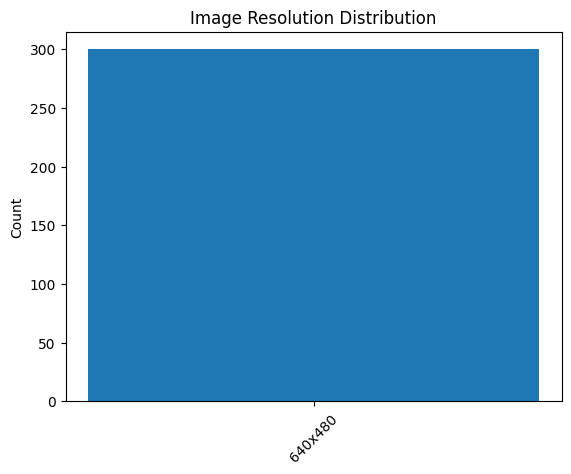

In [ ]:
from collections import Counter

size_counts = Counter(sizes)
labels = [f"{w}x{h}" for (w, h) in size_counts]
counts = list(size_counts.values())

plt.bar(labels, counts)
plt.xticks(rotation=45)
plt.title("Image Resolution Distribution")
plt.ylabel("Count")
plt.show()


In [ ]:
import cv2, numpy as np, os, pandas as pd
from tqdm import tqdm

def degrade_image(img):
    # Gaussian blur
    if np.random.rand() < 0.5:
        img = cv2.GaussianBlur(img, (5, 5), sigmaX=np.random.uniform(1.0, 3.0))

    # Brightness scaling
    if np.random.rand() < 0.5:
        factor = np.random.uniform(0.5, 1.5)
        img = np.clip(img.astype(np.float32) * factor, 0, 255).astype(np.uint8)

    # Safe Gaussian noise
    if np.random.rand() < 0.5:
        noise = np.random.normal(0, 10, img.shape).astype(np.float32)
        img = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    return img

orig_df = pd.read_csv("/content/drive/MyDrive/AML-PROJECT/iris.csv")
expanded = []

save_dir = "/content/drive/MyDrive/AML-PROJECT/degraded"
os.makedirs(save_dir, exist_ok=True)

for idx, row in tqdm(orig_df.iterrows(), total=len(orig_df)):
    img = cv2.imread(row.Path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    # Degrade image
    deg = degrade_image(img)

    # Check for excessive corruption
    if np.std(deg) < 5 or np.mean(deg) < 10 or np.mean(deg) > 245:
        continue

    # Save image
    fname = f"{row.Label}_deg_{idx}.png"
    path = os.path.join(save_dir, fname)
    cv2.imwrite(path, deg)

    expanded.append({"Label": row.Label, "Path": path})

expanded_df = pd.DataFrame(expanded)
df_full = pd.concat([orig_df, expanded_df], ignore_index=True)
df_full.to_csv("/content/drive/MyDrive/AML-PROJECT/iris_expanded.csv", index=False)


100%|██████████| 20000/20000 [2:17:05<00:00,  2.43it/s]


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np

IMG_H, IMG_W = 120, 160

# --- Preprocessing ---
def stretch_contrast(img):
    p2, p98 = np.percentile(img, (2, 98))
    return np.clip((img - p2) * 255.0 / (p98 - p2), 0, 255).astype(np.uint8)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def segment_and_crop_iris(img):
    h, w = img.shape
    blurred = cv2.medianBlur(img, 5)
    circles = cv2.HoughCircles(
        blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=h/4,
        param1=50, param2=30, minRadius=int(h*0.1), maxRadius=int(h*0.4)
    )
    if circles is not None:
        circles = np.round(circles[0, :]).astype(int)
        x, y, r = circles[0]
        side = int(2.5 * r)
        x1, y1 = max(0, x - side), max(0, y - side)
        x2, y2 = min(w, x + side), min(h, y + side)
        cropped = img[y1:y2, x1:x2]
    else:
        side = min(h, w)
        mid_h, mid_w = h // 2, w // 2
        half = side // 2
        cropped = img[mid_h-half:mid_h+half, mid_w-half:mid_w+half]
    return cropped

def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return np.zeros((IMG_H, IMG_W), dtype=np.float32)
    img = stretch_contrast(img)
    img = apply_clahe(img)
    img = segment_and_crop_iris(img)
    img = cv2.resize(img, (IMG_W, IMG_H))
    return img / 255.0

def augment(image):
    image = tf.expand_dims(image, -1)
    if tf.random.uniform([]) > 0.5:
        image = tf.image.random_brightness(image, 0.1)
    if tf.random.uniform([]) > 0.5:
        image = tf.image.random_contrast(image, 0.7, 1.4)
    if tf.random.uniform([]) > 0.5:
        image = tf.image.random_flip_left_right(image)
    image = tf.squeeze(tf.clip_by_value(image, 0., 1.), -1)
    return image


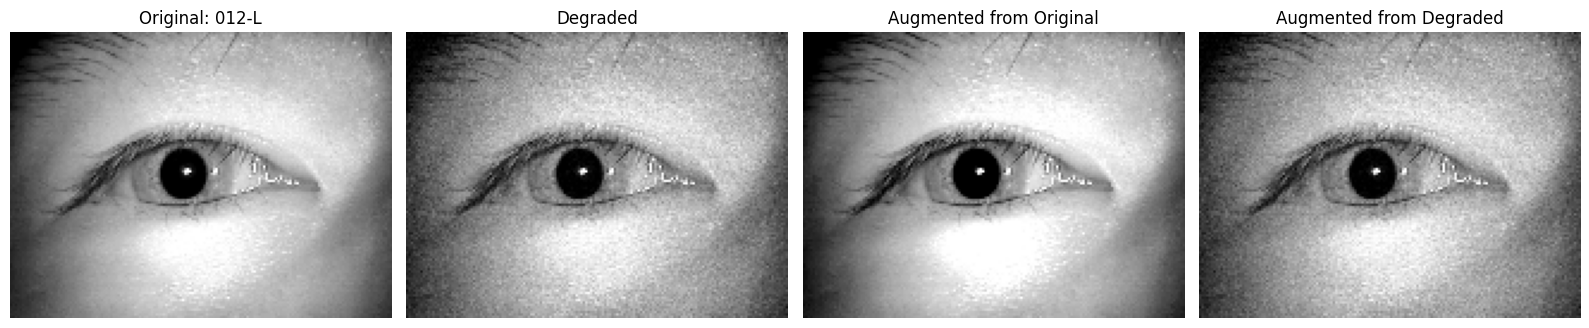

In [ ]:
import matplotlib.pyplot as plt

def compare_all_samples(df, label, eye='L'):
    orig_row = df[(df['Label'] == f"{label}-{eye}") & (~df['Path'].str.contains('deg'))].sample(1).iloc[0]
    deg_row = df[(df['Label'] == f"{label}-{eye}") & (df['Path'].str.contains('deg'))].sample(1).iloc[0]

    orig = preprocess_image(orig_row.Path)
    deg = preprocess_image(deg_row.Path)

    aug_orig = augment(tf.convert_to_tensor(orig)).numpy()
    aug_deg = augment(tf.convert_to_tensor(deg)).numpy()

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(orig, cmap='gray')
    plt.title(f"Original: {label}-{eye}")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(deg, cmap='gray')
    plt.title("Degraded")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(aug_orig, cmap='gray')
    plt.title("Augmented from Original")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(aug_deg, cmap='gray')
    plt.title("Augmented from Degraded")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

compare_all_samples(df_full, label='012', eye='L')

In [ ]:
import pandas as pd
import os

original_df = pd.read_csv("/content/drive/MyDrive/AML-PROJECT/iris.csv")
print("Original Total samples:", len(original_df))
print("Unique identities:", original_df['Label'].nunique()/2)


combined_df = pd.read_csv("/content/drive/MyDrive/AML-PROJECT/iris_expanded.csv")
print("Original and Degraded Total samples:", len(combined_df))
print("Unique identities:", combined_df['Label'].nunique()/2)


Original Total samples: 20000
Unique identities: 1000.0
Original and Degraded Total samples: 37567
Unique identities: 1000.0


Original: /content/drive//MyDrive/AML-PROJECT/CASIA-Iris-Thousand/002/R/S5002R00.jpg Exists: True
Degraded: /content/drive/MyDrive/AML-PROJECT/degraded/002-R_deg_50.png Exists: True
Noisy   : /content/drive/MyDrive/AML-PROJECT/623final_all/002-R_aug_17050.png Exists: True


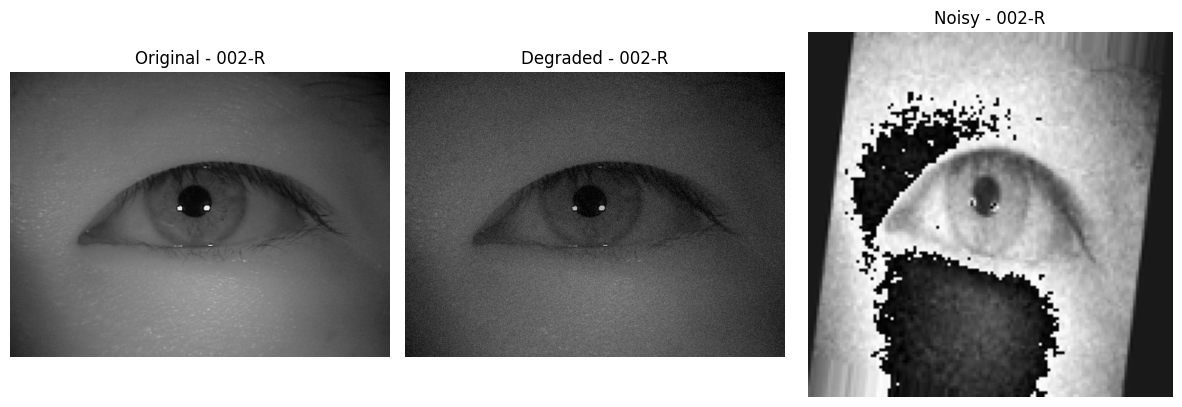

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

df_original = pd.read_csv('/content/drive/MyDrive/AML-PROJECT/iris.csv')
df_degraded = pd.read_csv('/content/drive/MyDrive/AML-PROJECT/iris_degrade.csv')
df_noisy = pd.read_csv('/content/drive/MyDrive/AML-PROJECT/623final_all.csv')

df_original.columns = df_original.columns.str.lower()
df_degraded.columns = df_degraded.columns.str.lower()
df_noisy.columns = df_noisy.columns.str.lower()
df_noisy = df_noisy.rename(columns={"image_path": "path"})

label_to_compare = '002-R'

path_original = df_original[df_original['label'] == label_to_compare]['path'].values[0]
path_degraded = df_degraded[df_degraded['label'] == label_to_compare]['path'].values[0]
path_noisy = df_noisy[df_noisy['label'] == label_to_compare]['path'].values[0]

print("Original:", path_original, "Exists:", os.path.exists(path_original))
print("Degraded:", path_degraded, "Exists:", os.path.exists(path_degraded))
print("Noisy   :", path_noisy, "Exists:", os.path.exists(path_noisy))

img_original = cv2.imread(path_original)
img_degraded = cv2.imread(path_degraded)
img_noisy = cv2.imread(path_noisy)

# Check if any failed
if img_original is None or img_degraded is None or img_noisy is None:
    print("One or more images could not be loaded. Check file paths above.")
else:
    # Convert for matplotlib
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img_degraded = cv2.cvtColor(img_degraded, cv2.COLOR_BGR2RGB)
    img_noisy = cv2.cvtColor(img_noisy, cv2.COLOR_BGR2RGB)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_original)
    plt.title(f"Original - {label_to_compare}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(img_degraded)
    plt.title(f"Degraded - {label_to_compare}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img_noisy)
    plt.title(f"Noisy - {label_to_compare}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
